In [1]:
%load_ext autoreload
%autoreload 2

In [29]:
from everything import do_everything_before, do_everything_between, do_everything_after, get_train_command, get_test_ssim_psnr
import numpy as np
import os
import torch
from srcnn_files.srcnn import SRCNN
import matplotlib.pyplot as plt
from PIL import Image
from interpolate import linear_interpolate
from scipy import fft
import tifffile
import cv2 as cv
from skimage.util.shape import view_as_windows
from error_algorithms import IoU, centroid_distances, ignore_duplicates
from skimage.morphology import binary_erosion, binary_closing, binary_dilation
from skimage.morphology import label

In [4]:
TEST_DIR_TILED_10  = "C:/Users/robho/OneDrive/Desktop/Uni_Work/Year_4/project2/superres/second_trial/omnipose_training/test/pmc_0.0655_tiled/"
TEST_DIR_TILED_60  = "C:/Users/robho/OneDrive/Desktop/Uni_Work/Year_4/project2/superres/second_trial/omnipose_training/test/pmc_0.1092_cubic_tiled/"
TEST_DIR_TILED_40  = "C:/Users/robho/OneDrive/Desktop/Uni_Work/Year_4/project2/superres/second_trial/omnipose_training/test/pmc_0.1638_cubic_tiled/"

In [5]:
paths_gt = [TEST_DIR_TILED_10 + file for file in os.listdir(TEST_DIR_TILED_10) if "_masks" in file]
paths_img_10 = [TEST_DIR_TILED_10 + file for file in os.listdir(TEST_DIR_TILED_10) if "_masks" not in file]
paths_img_60 = [TEST_DIR_TILED_60 + file for file in os.listdir(TEST_DIR_TILED_60) if "_masks" not in file]
paths_img_40 = [TEST_DIR_TILED_40 + file for file in os.listdir(TEST_DIR_TILED_40) if "_masks" not in file]

In [6]:
masks = []
imgs_10 = []
imgs_60 = []
imgs_40 = []

for gt,path_10,path_60,path_40 in zip(paths_gt,paths_img_10,paths_img_60,paths_img_40):
    mask = np.asarray(Image.open(gt))
    img_10 = np.asarray(Image.open(path_10))
    img_60 = np.asarray(Image.open(path_60))
    img_40 = np.asarray(Image.open(path_40))
    masks.append(mask)
    imgs_10.append(img_10)
    imgs_60.append(img_60)
    imgs_40.append(img_40)

In [7]:
fn_list_list_list_10 = []
thresholds_10 = []
for img in imgs_10:
    # find normalized_histogram, and its cumulative distribution function
    hist = cv.calcHist([img],[0],None,[256],[0,256])
    hist_norm = hist.ravel()/hist.sum()
    Q = hist_norm.cumsum()
    bins = np.arange(256)
    fn_min = np.inf
    thresh = -1
    fn_list_list = []
    v_list = []
    for i in range(1,256):
        fn_list = []
        for j in range(1,i+1):
            fn_list.append(-1)
        for j in range(i+1,256):
            p1,p2,p3 = np.hsplit(hist_norm,[i,j]) # probabilities
            q1,q2,q3 = Q[i],Q[j]-Q[i],Q[255]-Q[j] # cum sum of classes
            b1,b2,b3 = np.hsplit(bins,[i,j]) # weights
            # finding means and variances
            m1,m2,m3 =  0 if q1 == 0 else np.sum(p1*b1)/q1, 0 if q2 == 0 else np.sum(p2*b2)/q2, 0 if q3 == 0 else np.sum(p3*b3)/q3
            v1,v2,v3 = 0 if q1 == 0 else np.sum(((b1-m1)**2)*p1)/q1, 0 if q2 == 0 else np.sum(((b2-m2)**2)*p2)/q2, 0 if q3 == 0 else np.sum(((b3-m3)**2)*p3)/q3
            # v_list.append([v1,v2])
            # calculates the minimization function
            fn = v1*q1 + v2*q2 + v3*q3
            fn_list.append(fn)
            if fn < fn_min:
                fn_min = fn
                thresh1 = i
                thresh2 = j
        fn_list_list.append(fn_list)
    thresholds_10.append([thresh1,thresh2])
    fn_list_list_list_10.append(fn_list_list)

In [8]:
fn_list_list_list_60 = []
thresholds_60 = []
for img in imgs_60:
    # find normalized_histogram, and its cumulative distribution function
    hist = cv.calcHist([img],[0],None,[256],[0,256])
    hist_norm = hist.ravel()/hist.sum()
    Q = hist_norm.cumsum()
    bins = np.arange(256)
    fn_min = np.inf
    thresh = -1
    fn_list_list = []
    v_list = []
    for i in range(1,256):
        fn_list = []
        for j in range(1,i+1):
            fn_list.append(-1)
        for j in range(i+1,256):
            p1,p2,p3 = np.hsplit(hist_norm,[i,j]) # probabilities
            q1,q2,q3 = Q[i],Q[j]-Q[i],Q[255]-Q[j] # cum sum of classes
            b1,b2,b3 = np.hsplit(bins,[i,j]) # weights
            # finding means and variances
            m1,m2,m3 =  0 if q1 == 0 else np.sum(p1*b1)/q1, 0 if q2 == 0 else np.sum(p2*b2)/q2, 0 if q3 == 0 else np.sum(p3*b3)/q3
            v1,v2,v3 = 0 if q1 == 0 else np.sum(((b1-m1)**2)*p1)/q1, 0 if q2 == 0 else np.sum(((b2-m2)**2)*p2)/q2, 0 if q3 == 0 else np.sum(((b3-m3)**2)*p3)/q3
            # v_list.append([v1,v2])
            # calculates the minimization function
            fn = v1*q1 + v2*q2 + v3*q3
            fn_list.append(fn)
            if fn < fn_min:
                fn_min = fn
                thresh1 = i
                thresh2 = j
        fn_list_list.append(fn_list)
    thresholds_60.append([thresh1,thresh2])
    fn_list_list_list_60.append(fn_list_list)

In [9]:
fn_list_list_list_40 = []
thresholds_40 = []
for img in imgs_40:
    # find normalized_histogram, and its cumulative distribution function
    hist = cv.calcHist([img],[0],None,[256],[0,256])
    hist_norm = hist.ravel()/hist.sum()
    Q = hist_norm.cumsum()
    bins = np.arange(256)
    fn_min = np.inf
    thresh = -1
    fn_list_list = []
    v_list = []
    for i in range(1,256):
        fn_list = []
        for j in range(1,i+1):
            fn_list.append(-1)
        for j in range(i+1,256):
            p1,p2,p3 = np.hsplit(hist_norm,[i,j]) # probabilities
            q1,q2,q3 = Q[i],Q[j]-Q[i],Q[255]-Q[j] # cum sum of classes
            b1,b2,b3 = np.hsplit(bins,[i,j]) # weights
            # finding means and variances
            m1,m2,m3 =  0 if q1 == 0 else np.sum(p1*b1)/q1, 0 if q2 == 0 else np.sum(p2*b2)/q2, 0 if q3 == 0 else np.sum(p3*b3)/q3
            v1,v2,v3 = 0 if q1 == 0 else np.sum(((b1-m1)**2)*p1)/q1, 0 if q2 == 0 else np.sum(((b2-m2)**2)*p2)/q2, 0 if q3 == 0 else np.sum(((b3-m3)**2)*p3)/q3
            # v_list.append([v1,v2])
            # calculates the minimization function
            fn = v1*q1 + v2*q2 + v3*q3
            fn_list.append(fn)
            if fn < fn_min:
                fn_min = fn
                thresh1 = i
                thresh2 = j
        fn_list_list.append(fn_list)
    thresholds_40.append([thresh1,thresh2])
    fn_list_list_list_40.append(fn_list_list)

In [10]:
thresholds_10

[[43, 111], [43, 111], [43, 112], [43, 111], [43, 111]]

In [11]:
thresholds_60

[[42, 110], [41, 109], [41, 110], [41, 109], [41, 110]]

In [12]:
thresholds_40

[[47, 116], [47, 117], [48, 117], [47, 116], [47, 116]]

In [71]:
seg_10 = []
for i,img in enumerate(imgs_10):
    thresh1, thresh2 = thresholds_10[i]
    # thresh1, thresh2 = 30, 100
    # global thresholding
    # ret1,th1 = cv.threshold(img,0,255,cv.THRESH_OTSU)
    # Otsu's thresholding
    ret1,th1 = cv.threshold(img,thresh1,255,cv.THRESH_BINARY)
    ret2,th2 = cv.threshold(img,thresh2,255,cv.THRESH_BINARY_INV)
    th3 = np.logical_and(binary_dilation(binary_dilation(th1))*255==255,th2==255)
    seg_10.append(label(binary_erosion(binary_erosion(th3))))

    # fig, axs = plt.subplots(1,5,figsize=[12,3],gridspec_kw={'width_ratios': [1,1,1,1,4]})
    # axs[0].imshow(img,'gray')
    # axs[1].imshow(th1,'gray')
    # axs[2].imshow(th2,'gray')
    # axs[3].imshow(th3,'gray')
    # axs[4].hist(img.ravel(),256,label="hist")
    # axs[4].hist([0]+[255]+[thresh1]*350,256,color="red",label=f"threshold 1: {thresh1}")
    # axs[4].hist([0]+[255]+[thresh2]*350,256,color="purple",label=f"threshold 2: {thresh2}")
    # axs[4].legend()
    # fig.tight_layout()
    # plt.show()

In [72]:
seg_60 = []
for i,img in enumerate(imgs_60):
    thresh1, thresh2 = thresholds_60[i]
    # thresh1, thresh2 = 30, 100
    # global thresholding
    # ret1,th1 = cv.threshold(img,0,255,cv.THRESH_OTSU)
    # Otsu's thresholding
    ret1,th1 = cv.threshold(img,thresh1,255,cv.THRESH_BINARY)
    ret2,th2 = cv.threshold(img,thresh2,255,cv.THRESH_BINARY_INV)
    th3 = np.logical_and(binary_dilation(binary_dilation(th1))*255==255,th2==255)
    seg_60.append(label(binary_erosion(binary_erosion(th3))))

    # fig, axs = plt.subplots(1,5,figsize=[12,3],gridspec_kw={'width_ratios': [1,1,1,1,4]})
    # axs[0].imshow(img,'gray')
    # axs[1].imshow(th1,'gray')
    # axs[2].imshow(th2,'gray')
    # axs[3].imshow(th3,'gray')
    # axs[4].hist(img.ravel(),256,label="hist")
    # axs[4].hist([0]+[255]+[thresh1]*350,256,color="red",label=f"threshold 1: {thresh1}")
    # axs[4].hist([0]+[255]+[thresh2]*350,256,color="purple",label=f"threshold 2: {thresh2}")
    # axs[4].legend()
    # fig.tight_layout()
    # plt.show()

In [73]:
seg_40 = []
for i,img in enumerate(imgs_40):
    thresh1, thresh2 = thresholds_40[i]
    # thresh1, thresh2 = 30, 100
    # global thresholding
    # ret1,th1 = cv.threshold(img,0,255,cv.THRESH_OTSU)
    # Otsu's thresholding
    ret1,th1 = cv.threshold(img,thresh1,255,cv.THRESH_BINARY)
    ret2,th2 = cv.threshold(img,thresh2,255,cv.THRESH_BINARY_INV)
    th3 = np.logical_and(binary_dilation(binary_dilation(th1))*255==255,th2==255)
    seg_40.append(label(binary_erosion(binary_erosion(th3))))

    # fig, axs = plt.subplots(1,5,figsize=[12,3],gridspec_kw={'width_ratios': [1,1,1,1,4]})
    # axs[0].imshow(img,'gray')
    # axs[1].imshow(th1,'gray')
    # axs[2].imshow(th2,'gray')
    # axs[3].imshow(th3,'gray')
    # axs[4].hist(img.ravel(),256,label="hist")
    # axs[4].hist([0]+[255]+[thresh1]*350,256,color="red",label=f"threshold 1: {thresh1}")
    # axs[4].hist([0]+[255]+[thresh2]*350,256,color="purple",label=f"threshold 2: {thresh2}")
    # axs[4].legend()
    # fig.tight_layout()
    # plt.show()

In [74]:
n = range(5)
TILE_LENGTH = 40
outlist = []
excesslist = []
nearlist = []
distlist = []
for i in n:
    mask = masks[i]
    seg = seg_10[i]
    # plt.imshow(mask,"gray")
    # plt.title(f"mask {i}")
    # plt.show()
    # plt.imshow(seg,"gray")
    # plt.title(f"seg {i}")
    # plt.show()
    width = mask.shape[1]//TILE_LENGTH
    for j in range(TILE_LENGTH):
        maskj = mask[:,width*j:width*(j+1)]
        segj = seg[:,width*j:width*(j+1)]
        out, excess = IoU(maskj,segj)
        outlist.append(out)
        excesslist.append(excess)
        nearest, dist = centroid_distances(maskj,segj)
        nearlist.append(nearest)
        distlist.append(dist)
cells_10, dists_10, duplicates_10, indices_10 = ignore_duplicates(nearlist, distlist)
dists = np.append(dists_10, [np.max(dists_10)]*duplicates_10)
perclist = []
for out in outlist:
    for a,b in out:
        perclist.append(a/b)
percarr_10 = np.array(perclist)
excessout = []
for exc in excesslist:
    excessout.extend(exc)
excessarr_10 = np.array(excessout)
# percarr, cells, dists, duplicates, indices, excessarr

In [75]:
n = range(5)
TILE_LENGTH = 40
outlist = []
excesslist = []
nearlist = []
distlist = []
for i in n:
    mask = masks[i]
    seg = seg_60[i]
    # plt.imshow(mask,"gray")
    # plt.title(f"mask {i}")
    # plt.show()
    # plt.imshow(seg,"gray")
    # plt.title(f"seg {i}")
    # plt.show()
    width = mask.shape[1]//TILE_LENGTH
    for j in range(TILE_LENGTH):
        maskj = mask[:,width*j:width*(j+1)]
        segj = seg[:,width*j:width*(j+1)]
        out, excess = IoU(maskj,segj)
        outlist.append(out)
        excesslist.append(excess)
        nearest, dist = centroid_distances(maskj,segj)
        nearlist.append(nearest)
        distlist.append(dist)
cells_60, dists_60, duplicates_60, indices_60 = ignore_duplicates(nearlist, distlist)
dists = np.append(dists_60, [np.max(dists_60)]*duplicates_60)
perclist = []
for out in outlist:
    for a,b in out:
        perclist.append(a/b)
percarr_60 = np.array(perclist)
excessout = []
for exc in excesslist:
    excessout.extend(exc)
excessarr_60 = np.array(excessout)
# percarr, cells, dists, duplicates, indices, excessarr

In [76]:
n = range(5)
TILE_LENGTH = 40
outlist = []
excesslist = []
nearlist = []
distlist = []
for i in n:
    mask = masks[i]
    seg = seg_40[i]
    # plt.imshow(mask,"gray")
    # plt.title(f"mask {i}")
    # plt.show()
    # plt.imshow(seg,"gray")
    # plt.title(f"seg {i}")
    # plt.show()
    width = mask.shape[1]//TILE_LENGTH
    for j in range(TILE_LENGTH):
        maskj = mask[:,width*j:width*(j+1)]
        segj = seg[:,width*j:width*(j+1)]
        out, excess = IoU(maskj,segj)
        outlist.append(out)
        excesslist.append(excess)
        nearest, dist = centroid_distances(maskj,segj)
        nearlist.append(nearest)
        distlist.append(dist)
cells_40, dists_40, duplicates_40, indices_40 = ignore_duplicates(nearlist, distlist)
dists = np.append(dists_40, [np.max(dists_40)]*duplicates_40)
perclist = []
for out in outlist:
    for a,b in out:
        perclist.append(a/b)
percarr_40 = np.array(perclist)
excessout = []
for exc in excesslist:
    excessout.extend(exc)
excessarr_40 = np.array(excessout)
# percarr, cells, dists, duplicates, indices, excessarr

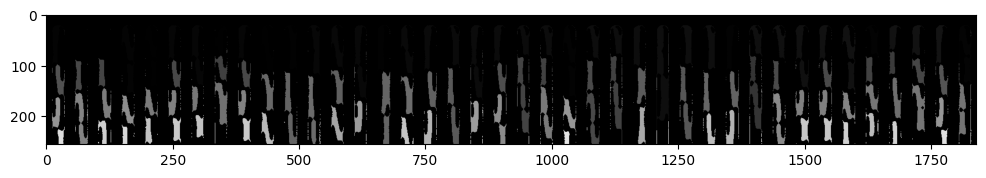

In [77]:
fig,axs=plt.subplots(1,1,figsize=[12,4])
axs.imshow(seg_60[2],"gray")
plt.show()

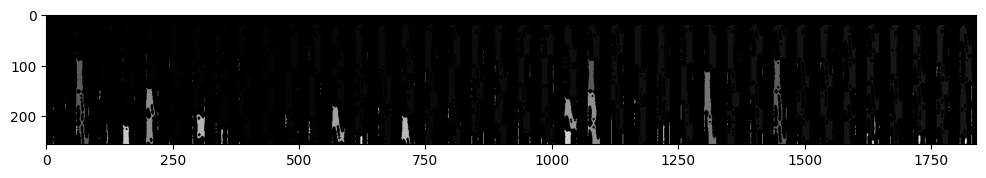

In [78]:
fig,axs=plt.subplots(1,1,figsize=[12,4])
axs.imshow(seg_40[2],"gray")
plt.show()

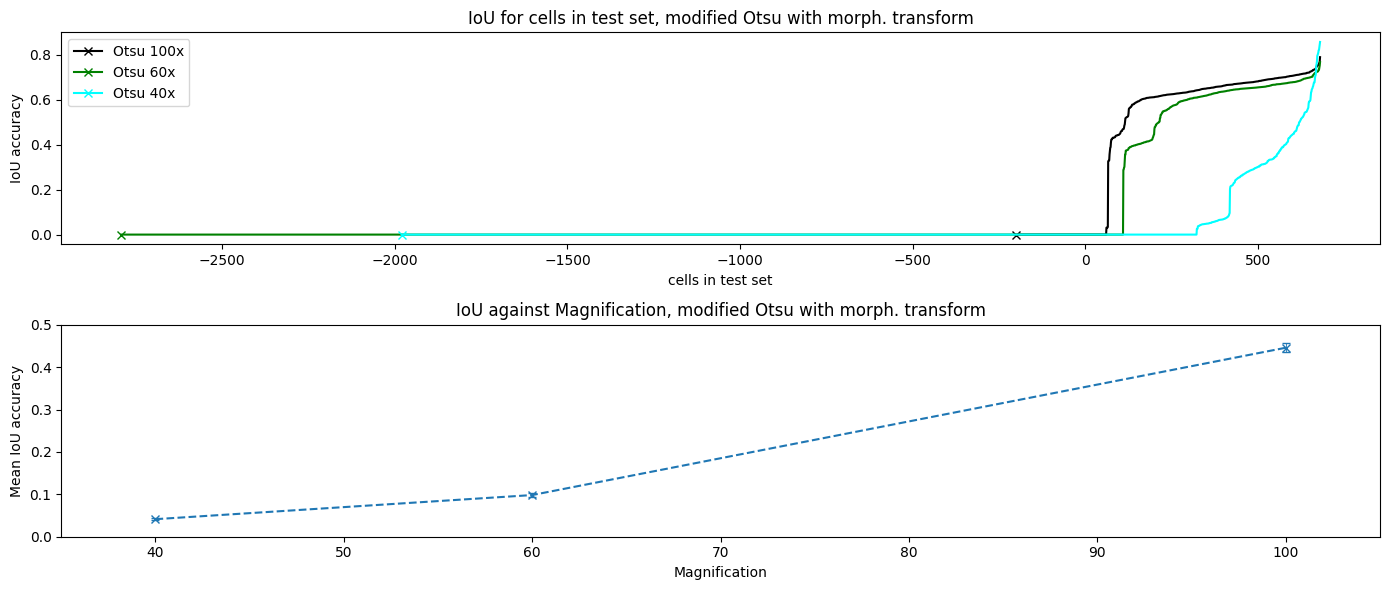

In [83]:
plot_10 = np.append(percarr_10,excessarr_10*0)
plot_60 = np.append(percarr_60,excessarr_60*0)
plot_40 = np.append(percarr_40,excessarr_40*0)

fig, axs = plt.subplots(2,1,figsize=(14,6))
axs[0].plot(np.arange(-len(excessarr_10),len(percarr_10)),np.sort(plot_10),"-",markevery=[0],marker="x",label="Otsu 100x",color="black")
axs[0].plot(np.arange(-len(excessarr_60),len(percarr_60)),np.sort(plot_60),"-",markevery=[0],marker="x",label="Otsu 60x",color="green")
axs[0].plot(np.arange(-len(excessarr_40),len(percarr_40)),np.sort(plot_40),"-",markevery=[0],marker="x",label="Otsu 40x",color="cyan")
axs[0].set_title("IoU for cells in test set, modified Otsu with morph. transform")
axs[0].set_ylabel("IoU accuracy")
axs[0].set_xlabel("cells in test set")
axs[0].legend()

xx = [40,60,100]
yy = [plot_40,plot_60,plot_10]

axs[1].set_title("IoU against Magnification, modified Otsu with morph. transform")
axs[1].errorbar(xx,[np.mean(y) for y in yy],[np.std(y)/np.sqrt(len(y)) for y in yy],linestyle="--",ecolor='C0',elinewidth=0.6,capsize=3,marker='x',color='C0')
axs[1].set_ylabel("Mean IoU accuracy")
axs[1].set_xlabel("Magnification")
axs[1].set_ylim(0,0.5)
axs[1].set_xlim(35,105)
fig.tight_layout()
plt.savefig("C:/Users/robho/OneDrive/Desktop/Uni_Work/Year_4/project2/report_images/otsu_pc_morph.pdf")
plt.show()

In [84]:
[np.mean(y) for y in yy]


[0.041414678187058754, 0.09832588988549217, 0.4459628328285601]

In [ ]:
[np.mean(y) for y in yy]

[0.06323854435588809, 0.0768468958338821, 0.07929850170659022]

In [ ]:
plot_90 = np.append(percarr_90_linear,excess_90_linear*0)
plot_60 = np.append(percarr_60_linear,excess_60_linear*0)
plot_40 = np.append(percarr_40_linear,excess_40_linear*0)
plot_30 = np.append(percarr_30_linear,excess_30_linear*0)
plot_20 = np.append(percarr_20_linear,excess_20_linear*0)

fig, axs = plt.subplots(2,1,figsize=(14,6))
axs[0].plot(np.arange(-len(excess_90_linear),len(percarr_90_linear)),np.sort(plot_90),"-", markevery=[0],marker="x",label="90x",color="black")
axs[0].plot(np.arange(-len(excess_60_linear),len(percarr_60_linear)),np.sort(plot_60),"--",markevery=[0],marker="x",label="linear 60x",color="green")
axs[0].plot(np.arange(-len(excess_40_linear),len(percarr_40_linear)),np.sort(plot_40),"--",markevery=[0],marker="x",label="linear 40x",color="cyan")
axs[0].plot(np.arange(-len(excess_30_linear),len(percarr_30_linear)),np.sort(plot_30),"--",markevery=[0],marker="x",label="linear 30x",color="blue")
axs[0].plot(np.arange(-len(excess_20_linear),len(percarr_20_linear)),np.sort(plot_20),"--",markevery=[0],marker="x",label="linear 20x",color="purple")
axs[0].plot([-175,750],[0.8,0.8],color='black',linewidth=0.6,alpha=0.3)
axs[0].plot([-175,750],[0.6,0.6],color='black',linewidth=0.6,alpha=0.3)
axs[0].plot([-175,750],[0.4,0.4],color='black',linewidth=0.6,alpha=0.3)
axs[0].plot([-175,750],[0.2,0.2],color='black',linewidth=0.6,alpha=0.3)
axs[0].plot([-175,750],[0.1,0.1],color='black',linewidth=0.6,alpha=0.3)
axs[0].plot([-175,750],[0.3,0.3],color='black',linewidth=0.6,alpha=0.3)
axs[0].plot([-175,750],[0.9,0.9],color='black',linewidth=0.6,alpha=0.3)
axs[0].plot([-175,750],[0.7,0.7],color='black',linewidth=0.6,alpha=0.3)
axs[0].plot([-175,750],[0.5,0.5],color='black',linewidth=0.6,alpha=0.3)
axs[0].plot([-175,750],[0  ,0  ],color='black',linewidth=0.6,alpha=0.3)
axs[0].set_title("IoU accuracy for different magnifications")
axs[0].set_ylabel("IoU accuracy")
axs[0].set_xlabel("ground truth cells in test set")
axs[0].set_ylim(None,1)
axs[0].set_xlim(-175,750)
axs[0].legend()

xx = [20,30,40,60,90]
yy = [plot_20,plot_30,plot_40,plot_60,plot_90]

sq = np.sqrt(len(percarr_90_linear))

axs[1].set_title("IoU accuracy against Magnification")
axs[1].errorbar(xx,[np.mean(y) for y in yy],[np.std(y)/sq for y in yy],linestyle="--",ecolor='C0',elinewidth=0.6,capsize=3,marker='x',label='ID accuracy',color='C0')
# axs[1].plot([15,105],[1,1],color='black',linewidth=0.6,alpha=0.5)
axs[1].plot([15,105],[0.8,0.8],color='black',linewidth=0.6,alpha=0.5)
axs[1].plot([15,105],[0.6,0.6],color='black',linewidth=0.6,alpha=0.5)
axs[1].plot([15,105],[0.4,0.4],color='black',linewidth=0.6,alpha=0.5)
axs[1].plot([15,105],[0.2,0.2],color='black',linewidth=0.6,alpha=0.5)
axs[1].plot([15,105],[0.1,0.1],color='black',linewidth=0.6,alpha=0.5)
axs[1].plot([15,105],[0.3,0.3],color='black',linewidth=0.6,alpha=0.5)
axs[1].plot([15,105],[0.9,0.9],color='black',linewidth=0.6,alpha=0.5)
axs[1].plot([15,105],[0.7,0.7],color='black',linewidth=0.6,alpha=0.5)
axs[1].plot([15,105],[0.5,0.5],color='black',linewidth=0.6,alpha=0.5)
axs[1].set_ylabel("Mean IoU accuracy")
axs[1].set_xlabel("Magnification")
axs[1].set_ylim(0,1)
axs[1].set_xlim(15,95)
fig.tight_layout()
plt.show()

In [ ]:
plot_60_sr = np.append(percarr_60_sr_linear,excess_60_sr_linear*0)
plot_40_sr = np.append(percarr_40_sr_linear,excess_40_sr_linear*0)
plot_30_sr = np.append(percarr_30_sr_linear,excess_30_sr_linear*0)
plot_20_sr = np.append(percarr_20_sr_linear,excess_20_sr_linear*0)

fig, axs = plt.subplots(2,1,figsize=(14,7))
axs[0].plot(np.arange(-len(excess_90_linear),len(percarr_90_linear)),np.sort(plot_90),"-", markevery=[0],marker="x",label="90x",color="black")
axs[0].plot(np.arange(-len(excess_60_sr_linear),len(percarr_60_sr_linear)),np.sort(plot_60_sr),"-",markevery=[0],marker="x",label="SRCNN 60x",color="green")
axs[0].plot(np.arange(-len(excess_40_sr_linear),len(percarr_40_sr_linear)),np.sort(plot_40_sr),"-",markevery=[0],marker="x",label="SRCNN 40x",color="cyan")
axs[0].plot(np.arange(-len(excess_30_sr_linear),len(percarr_30_sr_linear)),np.sort(plot_30_sr),"-",markevery=[0],marker="x",label="SRCNN 30x",color="blue")
axs[0].plot(np.arange(-len(excess_20_sr_linear),len(percarr_20_sr_linear)),np.sort(plot_20_sr),"-",markevery=[0],marker="x",label="SRCNN 20x",color="purple")
# axs[0].plot([-175,750],[0.8,0.8],color='black',linewidth=0.6,alpha=0.3)
# axs[0].plot([-175,750],[0.6,0.6],color='black',linewidth=0.6,alpha=0.3)
# axs[0].plot([-175,750],[0.4,0.4],color='black',linewidth=0.6,alpha=0.3)
# axs[0].plot([-175,750],[0.2,0.2],color='black',linewidth=0.6,alpha=0.3)
# axs[0].plot([-175,750],[0.1,0.1],color='black',linewidth=0.6,alpha=0.3)
# axs[0].plot([-175,750],[0.3,0.3],color='black',linewidth=0.6,alpha=0.3)
# axs[0].plot([-175,750],[0.9,0.9],color='black',linewidth=0.6,alpha=0.3)
# axs[0].plot([-175,750],[0.7,0.7],color='black',linewidth=0.6,alpha=0.3)
# axs[0].plot([-175,750],[0.5,0.5],color='black',linewidth=0.6,alpha=0.3)
# axs[0].plot([-175,750],[0  ,0  ],color='black',linewidth=0.6,alpha=0.3)
axs[0].set_title("IoU for cells in test set, SRCNN")
axs[0].set_ylabel("IoU accuracy")
axs[0].set_xlabel("cells in test set")
axs[0].set_ylim(None,1)
axs[0].set_xlim(-70,750)
axs[0].legend()

xx = [20,30,40,60,90]
yy = [plot_20,plot_30,plot_40,plot_60,plot_90]
yy2 = [plot_20_sr,plot_30_sr,plot_40_sr,plot_60_sr,plot_90]

axs[1].set_title("IoU against Magnification, SRCNN")
axs[1].errorbar(xx,[np.mean(y) for y in yy2],[np.std(y)/sq for y in yy2],linestyle="-",ecolor='C2',elinewidth=0.6,capsize=3,marker='x',label='SR',color='C2')
# axs[1].plot([15,105],[1,1],color='black',linewidth=0.6)
# axs[1].plot([15,105],[0.8,0.8],color='black',linewidth=0.6,alpha=0.5)
# axs[1].plot([15,105],[0.6,0.6],color='black',linewidth=0.6,alpha=0.5)
# axs[1].plot([15,105],[0.4,0.4],color='black',linewidth=0.6,alpha=0.5)
# axs[1].plot([15,105],[0.2,0.2],color='black',linewidth=0.6,alpha=0.5)
# axs[1].plot([15,105],[0.1,0.1],color='black',linewidth=0.6,alpha=0.5)
# axs[1].plot([15,105],[0.3,0.3],color='black',linewidth=0.6,alpha=0.5)
# axs[1].plot([15,105],[0.9,0.9],color='black',linewidth=0.6,alpha=0.5)
# axs[1].plot([15,105],[0.7,0.7],color='black',linewidth=0.6,alpha=0.5)
# axs[1].plot([15,105],[0.5,0.5],color='black',linewidth=0.6,alpha=0.5)
axs[1].set_ylabel("Mean IoU accuracy")
axs[1].set_xlabel("Magnification")
axs[1].set_ylim(0,1)
axs[1].set_xlim(15,95)
fig.tight_layout()
plt.savefig("C:/Users/robho/OneDrive/Desktop/Uni_Work/Year_4/project2/report_images/srcnn_iou_only.pdf")
plt.show()

# due to over-segmentation tendency of omnipose?

In [ ]:
plot_60_sr = np.append(percarr_60_sr_linear,excess_60_sr_linear*0)
plot_40_sr = np.append(percarr_40_sr_linear,excess_40_sr_linear*0)
plot_30_sr = np.append(percarr_30_sr_linear,excess_30_sr_linear*0)
plot_20_sr = np.append(percarr_20_sr_linear,excess_20_sr_linear*0)

fig, axs = plt.subplots(2,1,figsize=(14,7))
axs[0].plot(np.arange(-len(excess_90_linear),len(percarr_90_linear)),np.sort(plot_90),"-", markevery=[0],marker="x",label="90x",color="black")
axs[0].plot(np.arange(-len(excess_60_sr_linear),len(percarr_60_sr_linear)),np.sort(plot_60_sr),"-",markevery=[0],marker="x",label="SR 60x",color="green")
axs[0].plot(np.arange(-len(excess_40_sr_linear),len(percarr_40_sr_linear)),np.sort(plot_40_sr),"-",markevery=[0],marker="x",label="SR 40x",color="cyan")
axs[0].plot(np.arange(-len(excess_30_sr_linear),len(percarr_30_sr_linear)),np.sort(plot_30_sr),"-",markevery=[0],marker="x",label="SR 30x",color="blue")
axs[0].plot(np.arange(-len(excess_20_sr_linear),len(percarr_20_sr_linear)),np.sort(plot_20_sr),"-",markevery=[0],marker="x",label="SR 20x",color="purple")
axs[0].plot(np.arange(-len(excess_60_linear),len(percarr_60_linear)),np.sort(plot_60),"--",markevery=[0],marker="o",label="linear 60x",color="green")
axs[0].plot(np.arange(-len(excess_40_linear),len(percarr_40_linear)),np.sort(plot_40),"--",markevery=[0],marker="o",label="linear 40x",color="cyan")
axs[0].plot(np.arange(-len(excess_30_linear),len(percarr_30_linear)),np.sort(plot_30),"--",markevery=[0],marker="o",label="linear 30x",color="blue")
axs[0].plot(np.arange(-len(excess_20_linear),len(percarr_20_linear)),np.sort(plot_20),"--",markevery=[0],marker="o",label="linear 20x",color="purple")
# axs[0].plot([-175,750],[0.8,0.8],color='black',linewidth=0.6,alpha=0.3)
# axs[0].plot([-175,750],[0.6,0.6],color='black',linewidth=0.6,alpha=0.3)
# axs[0].plot([-175,750],[0.4,0.4],color='black',linewidth=0.6,alpha=0.3)
# axs[0].plot([-175,750],[0.2,0.2],color='black',linewidth=0.6,alpha=0.3)
# axs[0].plot([-175,750],[0.1,0.1],color='black',linewidth=0.6,alpha=0.3)
# axs[0].plot([-175,750],[0.3,0.3],color='black',linewidth=0.6,alpha=0.3)
# axs[0].plot([-175,750],[0.9,0.9],color='black',linewidth=0.6,alpha=0.3)
# axs[0].plot([-175,750],[0.7,0.7],color='black',linewidth=0.6,alpha=0.3)
# axs[0].plot([-175,750],[0.5,0.5],color='black',linewidth=0.6,alpha=0.3)
# axs[0].plot([-175,750],[0  ,0  ],color='black',linewidth=0.6,alpha=0.3)
axs[0].set_title("IoU for cells in test set, SRCNN & linear upsample")
axs[0].set_ylabel("IoU accuracy")
axs[0].set_xlabel("cells in test set")
axs[0].set_ylim(None,1)
axs[0].set_xlim(-175,750)
axs[0].legend()

xx = [20,30,40,60,90]
yy = [plot_20,plot_30,plot_40,plot_60,plot_90]
yy2 = [plot_20_sr,plot_30_sr,plot_40_sr,plot_60_sr,plot_90]

axs[1].set_title("IoU against Magnification, SRCNN & linear upsample")
axs[1].errorbar(xx,[np.mean(y) for y in yy2],[np.std(y)/sq for y in yy2],linestyle="-",ecolor='C2',elinewidth=0.6,capsize=3,marker='x',label='SR',color='C2')
axs[1].errorbar(xx,[np.mean(y) for y in yy],[np.std(y)/sq for y in yy],linestyle="--",ecolor='C0',elinewidth=0.6,capsize=3,marker='x',label='linear',color='C0')
# axs[1].plot([15,105],[1,1],color='black',linewidth=0.6)
# axs[1].plot([15,105],[0.8,0.8],color='black',linewidth=0.6,alpha=0.5)
# axs[1].plot([15,105],[0.6,0.6],color='black',linewidth=0.6,alpha=0.5)
# axs[1].plot([15,105],[0.4,0.4],color='black',linewidth=0.6,alpha=0.5)
# axs[1].plot([15,105],[0.2,0.2],color='black',linewidth=0.6,alpha=0.5)
# axs[1].plot([15,105],[0.1,0.1],color='black',linewidth=0.6,alpha=0.5)
# axs[1].plot([15,105],[0.3,0.3],color='black',linewidth=0.6,alpha=0.5)
# axs[1].plot([15,105],[0.9,0.9],color='black',linewidth=0.6,alpha=0.5)
# axs[1].plot([15,105],[0.7,0.7],color='black',linewidth=0.6,alpha=0.5)
# axs[1].plot([15,105],[0.5,0.5],color='black',linewidth=0.6,alpha=0.5)
axs[1].set_ylabel("Mean IoU accuracy")
axs[1].set_xlabel("Magnification")
axs[1].set_ylim(0,1)
axs[1].set_xlim(15,95)
axs[1].legend()
fig.tight_layout()
plt.savefig("C:/Users/robho/OneDrive/Desktop/Uni_Work/Year_4/project2/report_images/srcnn_iou.pdf")
plt.show()

In [ ]:
[np.mean(y) for y in yy2]

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(14,4))
axs[0].plot(np.sort(percarr_90_linear),"-",label="90x",color="black")
axs[0].plot(np.sort(percarr_60_sr_linear),"-",label="SR 60x",color="green")
axs[0].plot(np.sort(percarr_40_sr_linear),"-",label="SR 40x",color="cyan")
axs[0].plot(np.sort(percarr_30_sr_linear),"-",label="SR 30x",color="blue")
axs[0].plot(np.sort(percarr_20_sr_linear),"-",label="SR 20x",color="purple")
axs[0].plot(np.sort(percarr_60_linear),"--",label="linear 60x",color="green")
axs[0].plot(np.sort(percarr_40_linear),"--",label="linear 40x",color="cyan")
axs[0].plot(np.sort(percarr_30_linear),"--",label="linear 30x",color="blue")
axs[0].plot(np.sort(percarr_20_linear),"--",label="linear 20x",color="purple")
axs[0].set_title("IoU accuracy for different image types")
axs[0].set_ylabel("IoU accuracy")
# axs[0].set_ylim(0.8,1)
axs[0].legend(loc=[1.02,0.3])
axs[1].plot(np.sort(dists_90_linear),"-",label="90x",color="black")
axs[1].plot(np.sort(dists_60_sr_linear),"-",label="SR 60x",color="green")
axs[1].plot(np.sort(dists_40_sr_linear),"-",label="SR 40x",color="cyan")
axs[1].plot(np.sort(dists_30_sr_linear),"-",label="SR 30x",color="blue")
axs[1].plot(np.sort(dists_20_sr_linear),"-",label="SR 20x",color="purple")
axs[1].plot(np.sort(dists_60_linear),"--",label="linear 60x",color="green")
axs[1].plot(np.sort(dists_40_linear),"--",label="linear 40x",color="cyan")
axs[1].plot(np.sort(dists_30_linear),"--",label="linear 30x",color="blue")
axs[1].plot(np.sort(dists_20_linear),"--",label="linear 20x",color="purple")
axs[1].set_title("centroid distances for different image types")
axs[1].set_ylabel("distance (pixels)")
axs[1].set_ylim(0,5)
axs[1].legend(loc=[1.02,0.3])
fig.tight_layout()
plt.show()

In [ ]:
HR_IMAGES_DIR_90 = "C:/Users/robho/OneDrive/Desktop/Uni_Work/Year_4/project2/superres/third_trial/omnipose_training/test/pmc_0.0728/convolutions/"
SR_IMAGES_DIR_60 = "C:/Users/robho/OneDrive/Desktop/Uni_Work/Year_4/project2/superres/third_trial/omnipose_training/test/pmc_0.1092_linear_SR/"
SR_IMAGES_DIR_40 = "C:/Users/robho/OneDrive/Desktop/Uni_Work/Year_4/project2/superres/third_trial/omnipose_training/test/pmc_0.1638_linear_SR/"
SR_IMAGES_DIR_30 = "C:/Users/robho/OneDrive/Desktop/Uni_Work/Year_4/project2/superres/third_trial/omnipose_training/test/pmc_0.2184_linear_SR/"
SR_IMAGES_DIR_20 = "C:/Users/robho/OneDrive/Desktop/Uni_Work/Year_4/project2/superres/third_trial/omnipose_training/test/pmc_0.3276_linear_SR/"
LINEAR_IMAGES_DIR_60 = "C:/Users/robho/OneDrive/Desktop/Uni_Work/Year_4/project2/superres/third_trial/omnipose_training/test/pmc_0.1092_linear/"
LINEAR_IMAGES_DIR_40 = "C:/Users/robho/OneDrive/Desktop/Uni_Work/Year_4/project2/superres/third_trial/omnipose_training/test/pmc_0.1638_linear/"
LINEAR_IMAGES_DIR_30 = "C:/Users/robho/OneDrive/Desktop/Uni_Work/Year_4/project2/superres/third_trial/omnipose_training/test/pmc_0.2184_linear/"
LINEAR_IMAGES_DIR_20 = "C:/Users/robho/OneDrive/Desktop/Uni_Work/Year_4/project2/superres/third_trial/omnipose_training/test/pmc_0.3276_linear/"

In [ ]:
ssim_list_60, psnr_list_60 = get_test_ssim_psnr(HR_IMAGES_DIR_90,SR_IMAGES_DIR_60)
ssim_list_40, psnr_list_40 = get_test_ssim_psnr(HR_IMAGES_DIR_90,SR_IMAGES_DIR_40)
ssim_list_30, psnr_list_30 = get_test_ssim_psnr(HR_IMAGES_DIR_90,SR_IMAGES_DIR_30)
ssim_list_20, psnr_list_20 = get_test_ssim_psnr(HR_IMAGES_DIR_90,SR_IMAGES_DIR_20)

ssim_list_60_linear, psnr_list_60_linear = get_test_ssim_psnr(HR_IMAGES_DIR_90,LINEAR_IMAGES_DIR_60)
ssim_list_40_linear, psnr_list_40_linear = get_test_ssim_psnr(HR_IMAGES_DIR_90,LINEAR_IMAGES_DIR_40)
ssim_list_30_linear, psnr_list_30_linear = get_test_ssim_psnr(HR_IMAGES_DIR_90,LINEAR_IMAGES_DIR_30)
ssim_list_20_linear, psnr_list_20_linear = get_test_ssim_psnr(HR_IMAGES_DIR_90,LINEAR_IMAGES_DIR_20)

In [ ]:
fig, axs = plt.subplots(2,1,figsize=(14,6))
axs[0].plot(np.sort(ssim_list_60),label="SRCNN 60x",color="green")
axs[0].plot(np.sort(ssim_list_40),label="SRCNN 40x",color="cyan")
axs[0].plot(np.sort(ssim_list_30),label="SRCNN 30x",color="blue")
axs[0].plot(np.sort(ssim_list_20),label="SRCNN 20x",color="purple")
axs[0].plot(np.sort(ssim_list_60_linear),"--",label="linear 60x",color="green")
axs[0].plot(np.sort(ssim_list_40_linear),"--",label="linear 40x",color="cyan")
axs[0].plot(np.sort(ssim_list_30_linear),"--",label="linear 30x",color="blue")
axs[0].plot(np.sort(ssim_list_20_linear),"--",label="linear 20x",color="purple")
# axs[0].plot([-10,210],[0.8,0.8],color='black',linewidth=0.6,alpha=0.3)
# axs[0].plot([-10,210],[0.6,0.6],color='black',linewidth=0.6,alpha=0.3)
# axs[0].plot([-10,210],[0.4,0.4],color='black',linewidth=0.6,alpha=0.3)
# axs[0].plot([-10,210],[0.2,0.2],color='black',linewidth=0.6,alpha=0.3)
# axs[0].plot([-10,210],[0.1,0.1],color='black',linewidth=0.6,alpha=0.3)
# axs[0].plot([-10,210],[0.3,0.3],color='black',linewidth=0.6,alpha=0.3)
# axs[0].plot([-10,210],[0.9,0.9],color='black',linewidth=0.6,alpha=0.3)
# axs[0].plot([-10,210],[0.7,0.7],color='black',linewidth=0.6,alpha=0.3)
# axs[0].plot([-10,210],[0.5,0.5],color='black',linewidth=0.6,alpha=0.3)
axs[0].set_xlabel("image number")
axs[0].set_ylabel("SSIM")
axs[0].set_title("SSIM for images in test set, SRCNN & linear upsample")
axs[0].legend(loc=[1.02,0.2])
axs[0].set_ylim(0,1)
axs[0].set_xlim(-10,210)

xx = [20,30,40,60]
yy = [ssim_list_20_linear,ssim_list_30_linear,ssim_list_40_linear,ssim_list_60_linear]
yy2 = [ssim_list_20,ssim_list_30,ssim_list_40,ssim_list_60]

axs[1].set_title("SSIM against Magnification, SRCNN & linear upsample")
axs[1].errorbar(xx,[np.mean(y) for y in yy2],[np.std(y) for y in yy2],linestyle="-",ecolor='C2',elinewidth=0.6,capsize=3,marker='x',label='SRCNN',color='C2')
axs[1].errorbar(xx,[np.mean(y) for y in yy],[np.std(y) for y in yy],linestyle="--",ecolor='C0',elinewidth=0.6,capsize=3,marker='x',label='linear',color='C0')
# axs[1].plot([15,105],[0.8,0.8],color='black',linewidth=0.6,alpha=0.3)
# axs[1].plot([15,105],[0.6,0.6],color='black',linewidth=0.6,alpha=0.3)
# axs[1].plot([15,105],[0.4,0.4],color='black',linewidth=0.6,alpha=0.3)
# axs[1].plot([15,105],[0.2,0.2],color='black',linewidth=0.6,alpha=0.3)
# axs[1].plot([15,105],[0.1,0.1],color='black',linewidth=0.6,alpha=0.3)
# axs[1].plot([15,105],[0.3,0.3],color='black',linewidth=0.6,alpha=0.3)
# axs[1].plot([15,105],[0.9,0.9],color='black',linewidth=0.6,alpha=0.3)
# axs[1].plot([15,105],[0.7,0.7],color='black',linewidth=0.6,alpha=0.3)
# axs[1].plot([15,105],[0.5,0.5],color='black',linewidth=0.6,alpha=0.3)
axs[1].set_ylabel("Mean SSIM value")
axs[1].set_xlabel("Magnification")
axs[1].set_ylim(0,1)
axs[1].set_xlim(15,65)
axs[1].legend(loc=[1.02,0.5])
fig.tight_layout()
# plt.savefig("C:/Users/robho/OneDrive/Desktop/Uni_Work/Year_4/project2/report_images/srcnn_ssim.pdf")
plt.show()

In [ ]:
fig, axs = plt.subplots(2,1,figsize=(14,6))
axs[0].plot(np.sort(ssim_list_60),label="SRCNN 60x",color="green")
axs[0].plot(np.sort(ssim_list_40),label="SRCNN 40x",color="cyan")
axs[0].plot(np.sort(ssim_list_30),label="SRCNN 30x",color="blue")
axs[0].plot(np.sort(ssim_list_20),label="SRCNN 20x",color="purple")
# axs[0].plot([-10,210],[0.8,0.8],color='black',linewidth=0.6,alpha=0.3)
# axs[0].plot([-10,210],[0.6,0.6],color='black',linewidth=0.6,alpha=0.3)
# axs[0].plot([-10,210],[0.4,0.4],color='black',linewidth=0.6,alpha=0.3)
# axs[0].plot([-10,210],[0.2,0.2],color='black',linewidth=0.6,alpha=0.3)
# axs[0].plot([-10,210],[0.1,0.1],color='black',linewidth=0.6,alpha=0.3)
# axs[0].plot([-10,210],[0.3,0.3],color='black',linewidth=0.6,alpha=0.3)
# axs[0].plot([-10,210],[0.9,0.9],color='black',linewidth=0.6,alpha=0.3)
# axs[0].plot([-10,210],[0.7,0.7],color='black',linewidth=0.6,alpha=0.3)
# axs[0].plot([-10,210],[0.5,0.5],color='black',linewidth=0.6,alpha=0.3)
axs[0].set_xlabel("image number")
axs[0].set_ylabel("SSIM")
axs[0].set_title("SSIM for images in test set")
axs[0].legend(loc=[1.02,0.3])
axs[0].set_ylim(0.675,0.85)
axs[0].set_xlim(-10,210)

xx = [20,30,40,60]
yy = [ssim_list_20_linear,ssim_list_30_linear,ssim_list_40_linear,ssim_list_60_linear]
yy2 = [ssim_list_20,ssim_list_30,ssim_list_40,ssim_list_60]

axs[1].set_title("SSIM against Magnification")
axs[1].errorbar(xx,[np.mean(y) for y in yy2],[np.std(y)/np.sqrt(200) for y in yy2],linestyle="-",ecolor='C2',elinewidth=0.6,capsize=3,marker='x',label='SRCNN',color='C2')
# axs[1].plot([15,105],[0.8,0.8],color='black',linewidth=0.6,alpha=0.3)
# axs[1].plot([15,105],[0.6,0.6],color='black',linewidth=0.6,alpha=0.3)
# axs[1].plot([15,105],[0.4,0.4],color='black',linewidth=0.6,alpha=0.3)
# axs[1].plot([15,105],[0.2,0.2],color='black',linewidth=0.6,alpha=0.3)
# axs[1].plot([15,105],[0.1,0.1],color='black',linewidth=0.6,alpha=0.3)
# axs[1].plot([15,105],[0.3,0.3],color='black',linewidth=0.6,alpha=0.3)
# axs[1].plot([15,105],[0.9,0.9],color='black',linewidth=0.6,alpha=0.3)
# axs[1].plot([15,105],[0.7,0.7],color='black',linewidth=0.6,alpha=0.3)
# axs[1].plot([15,105],[0.5,0.5],color='black',linewidth=0.6,alpha=0.3)
axs[1].set_ylabel("Mean SSIM value")
axs[1].set_xlabel("Magnification")
axs[1].set_ylim(0.74,0.82)
axs[1].set_xlim(15,65)
# axs[1].legend(loc=[1.02,0.5])
fig.tight_layout()
# plt.savefig("C:/Users/robho/OneDrive/Desktop/Uni_Work/Year_4/project2/report_images/srcnn_ssim_only.pdf")
plt.show()

In [ ]:
fig, axs = plt.subplots(2,1,figsize=(14,6))
axs[0].plot(np.sort(psnr_list_60),label="SRCNN 60x",color="green")
axs[0].plot(np.sort(psnr_list_40),label="SRCNN 40x",color="cyan")
axs[0].plot(np.sort(psnr_list_30),label="SRCNN 30x",color="blue")
axs[0].plot(np.sort(psnr_list_20),label="SRCNN 20x",color="purple")
axs[0].plot(np.sort(psnr_list_60_linear),"--",label="linear 60x",color="green")
axs[0].plot(np.sort(psnr_list_40_linear),"--",label="linear 40x",color="cyan")
axs[0].plot(np.sort(psnr_list_30_linear),"--",label="linear 30x",color="blue")
axs[0].plot(np.sort(psnr_list_20_linear),"--",label="linear 20x",color="purple")
# axs[0].plot([-10,210],[15,15],color='black',linewidth=0.6,alpha=0.3)
# axs[0].plot([-10,210],[16,16],color='black',linewidth=0.6,alpha=0.3)
# axs[0].plot([-10,210],[17,17],color='black',linewidth=0.6,alpha=0.3)
# axs[0].plot([-10,210],[18,18],color='black',linewidth=0.6,alpha=0.3)
# axs[0].plot([-10,210],[19,19],color='black',linewidth=0.6,alpha=0.3)
# axs[0].plot([-10,210],[20,20],color='black',linewidth=0.6,alpha=0.3)
# axs[0].plot([-10,210],[21,21],color='black',linewidth=0.6,alpha=0.3)
# axs[0].plot([-10,210],[22,22],color='black',linewidth=0.6,alpha=0.3)
# axs[0].plot([-10,210],[23,23],color='black',linewidth=0.6,alpha=0.3)
# axs[0].plot([-10,210],[24,24],color='black',linewidth=0.6,alpha=0.3)
# axs[0].plot([-10,210],[25,25],color='black',linewidth=0.6,alpha=0.3)
# axs[0].plot([-10,210],[26,26],color='black',linewidth=0.6,alpha=0.3)
# axs[0].plot([-10,210],[27,27],color='black',linewidth=0.6,alpha=0.3)
# axs[0].plot([-10,210],[28,28],color='black',linewidth=0.6,alpha=0.3)
# axs[0].plot([-10,210],[29,29],color='black',linewidth=0.6,alpha=0.3)
# axs[0].plot([-10,210],[30,30],color='black',linewidth=0.6,alpha=0.3)
# axs[0].plot([-10,210],[31,31],color='black',linewidth=0.6,alpha=0.3)
axs[0].set_xlabel("image number")
axs[0].set_ylabel("PSNR")
axs[0].set_ylim(14,32)
axs[0].set_xlim(-10,210)
axs[0].set_title("PSNR for images in test set, SRCNN & linear upsample")
axs[0].legend(loc=[1.02,0.2])
# axs[0].set_ylim(0,1)

xx = [20,30,40,60]
yy = [psnr_list_20_linear,psnr_list_30_linear,psnr_list_40_linear,psnr_list_60_linear]
yy2 = [psnr_list_20,psnr_list_30,psnr_list_40,psnr_list_60]

sq = np.sqrt(len(psnr_list_60_linear))

axs[1].set_title("PSNR against Magnification, SRCNN & linear upsample")
axs[1].errorbar(xx,[np.mean(y) for y in yy2],[np.std(y)/sq for y in yy2],linestyle="-",ecolor='C2',elinewidth=0.6,capsize=3,marker='x',label='SRCNN',color='C2')
axs[1].errorbar(xx,[np.mean(y) for y in yy],[np.std(y)/sq for y in yy],linestyle="--",ecolor='C0',elinewidth=0.6,capsize=3,marker='x',label='linear',color='C0')
# axs[1].plot([18,62],[17,17],color='black',linewidth=0.6,alpha=0.3)
# axs[1].plot([18,62],[18,18],color='black',linewidth=0.6,alpha=0.3)
# axs[1].plot([18,62],[19,19],color='black',linewidth=0.6,alpha=0.3)
# axs[1].plot([18,62],[20,20],color='black',linewidth=0.6,alpha=0.3)
# axs[1].plot([18,62],[21,21],color='black',linewidth=0.6,alpha=0.3)
# axs[1].plot([18,62],[22,22],color='black',linewidth=0.6,alpha=0.3)
# axs[1].plot([18,62],[23,23],color='black',linewidth=0.6,alpha=0.3)
# axs[1].plot([18,62],[24,24],color='black',linewidth=0.6,alpha=0.3)
# axs[1].plot([18,62],[25,25],color='black',linewidth=0.6,alpha=0.3)
# axs[1].plot([18,62],[26,26],color='black',linewidth=0.6,alpha=0.3)
# axs[1].plot([18,62],[27,27],color='black',linewidth=0.6,alpha=0.3)
# axs[1].plot([18,62],[28,28],color='black',linewidth=0.6,alpha=0.3)
# axs[1].plot([18,62],[29,29],color='black',linewidth=0.6,alpha=0.3)
axs[1].set_ylabel("Mean PSNR value")
axs[1].set_xlabel("Magnification")
# axs[1].set_ylim(0,1)
# axs[1].set_xlim(15,65)
axs[1].legend(loc=[1.02,0.5])
axs[1].set_ylim(16,30)
axs[1].set_xlim(18,62)
fig.tight_layout()
# plt.savefig("C:/Users/robho/OneDrive/Desktop/Uni_Work/Year_4/project2/report_images/srcnn_psnr.pdf")
plt.show()

In [ ]:
fig, axs = plt.subplots(2,1,figsize=(14,6))
axs[0].plot(np.sort(psnr_list_60),label="SRCNN 60x",color="green")
axs[0].plot(np.sort(psnr_list_40),label="SRCNN 40x",color="cyan")
axs[0].plot(np.sort(psnr_list_30),label="SRCNN 30x",color="blue")
axs[0].plot(np.sort(psnr_list_20),label="SRCNN 20x",color="purple")
# axs[0].plot([-10,210],[15,15],color='black',linewidth=0.6,alpha=0.3)
# axs[0].plot([-10,210],[16,16],color='black',linewidth=0.6,alpha=0.3)
# axs[0].plot([-10,210],[17,17],color='black',linewidth=0.6,alpha=0.3)
# axs[0].plot([-10,210],[18,18],color='black',linewidth=0.6,alpha=0.3)
# axs[0].plot([-10,210],[19,19],color='black',linewidth=0.6,alpha=0.3)
# axs[0].plot([-10,210],[20,20],color='black',linewidth=0.6,alpha=0.3)
# axs[0].plot([-10,210],[21,21],color='black',linewidth=0.6,alpha=0.3)
# axs[0].plot([-10,210],[22,22],color='black',linewidth=0.6,alpha=0.3)
# axs[0].plot([-10,210],[23,23],color='black',linewidth=0.6,alpha=0.3)
# axs[0].plot([-10,210],[24,24],color='black',linewidth=0.6,alpha=0.3)
# axs[0].plot([-10,210],[25,25],color='black',linewidth=0.6,alpha=0.3)
# axs[0].plot([-10,210],[26,26],color='black',linewidth=0.6,alpha=0.3)
# axs[0].plot([-10,210],[27,27],color='black',linewidth=0.6,alpha=0.3)
# axs[0].plot([-10,210],[28,28],color='black',linewidth=0.6,alpha=0.3)
# axs[0].plot([-10,210],[29,29],color='black',linewidth=0.6,alpha=0.3)
# axs[0].plot([-10,210],[30,30],color='black',linewidth=0.6,alpha=0.3)
# axs[0].plot([-10,210],[31,31],color='black',linewidth=0.6,alpha=0.3)
axs[0].set_xlabel("image number")
axs[0].set_ylabel("PSNR")
# axs[0].set_ylim(14,32)
axs[0].set_xlim(-10,210)
axs[0].set_title("PSNR for images in test set")
axs[0].legend(loc=[1.02,0.3])
# axs[0].set_ylim(0,1)

xx = [20,30,40,60]
yy = [psnr_list_20_linear,psnr_list_30_linear,psnr_list_40_linear,psnr_list_60_linear]
yy2 = [psnr_list_20,psnr_list_30,psnr_list_40,psnr_list_60]

sq = np.sqrt(len(psnr_list_60_linear))

axs[1].set_title("PSNR against Magnification")
axs[1].errorbar(xx,[np.mean(y) for y in yy2],[np.std(y)/sq for y in yy2],linestyle="-",ecolor='C2',elinewidth=0.6,capsize=3,marker='x',label='SRCNN',color='C2')
# axs[1].plot([18,62],[17,17],color='black',linewidth=0.6,alpha=0.3)
# axs[1].plot([18,62],[18,18],color='black',linewidth=0.6,alpha=0.3)
# axs[1].plot([18,62],[19,19],color='black',linewidth=0.6,alpha=0.3)
# axs[1].plot([18,62],[20,20],color='black',linewidth=0.6,alpha=0.3)
# axs[1].plot([18,62],[21,21],color='black',linewidth=0.6,alpha=0.3)
# axs[1].plot([18,62],[22,22],color='black',linewidth=0.6,alpha=0.3)
# axs[1].plot([18,62],[23,23],color='black',linewidth=0.6,alpha=0.3)
# axs[1].plot([18,62],[24,24],color='black',linewidth=0.6,alpha=0.3)
# axs[1].plot([18,62],[25,25],color='black',linewidth=0.6,alpha=0.3)
# axs[1].plot([18,62],[26,26],color='black',linewidth=0.6,alpha=0.3)
# axs[1].plot([18,62],[27,27],color='black',linewidth=0.6,alpha=0.3)
# axs[1].plot([18,62],[28,28],color='black',linewidth=0.6,alpha=0.3)
# axs[1].plot([18,62],[29,29],color='black',linewidth=0.6,alpha=0.3)
axs[1].set_ylabel("Mean PSNR value")
axs[1].set_xlabel("Magnification")
# axs[1].set_ylim(0,1)
# axs[1].set_xlim(15,65)
# axs[1].legend(loc=[1.02,0.5])
axs[1].set_ylim(23,29)
axs[1].set_xlim(18,62)
fig.tight_layout()
# plt.savefig("C:/Users/robho/OneDrive/Desktop/Uni_Work/Year_4/project2/report_images/srcnn_psnr_only.pdf")
plt.show()